<a href="https://colab.research.google.com/github/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Laboratorio_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<img src="https://cursos.virtual.uniandes.edu.co/isis4219/wp-content/uploads/sites/162/2014/11/cropped-misisheader.png" ><br>
# Machine Learning Techniques - ISIS4219

Intersemestral 2020




# Objetivos

*   Aplicar la técnica de data augmentation a un conjunto de imagenes.
*   Construir un clasificador de imagenes a partir de una red neuronal convolucional (CNN).
*   Construir un clasificador de imagenes utilizando la tecnica de transfer learning.
*   Construir una red neuronal de tipo autoencoder para la eliminación de ruido en imagenes.



# Convolutional Neural Networks (CNN)


### 0. Configuración Inicial

##### 0.1 Validando la configuración CPU/GPU

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1473730618399083235
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18271836988239241911
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 42801232524202952
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11150726272
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8096550006648517785
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
!nvidia-smi

Wed Jul 22 21:33:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    56W / 149W |    130MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [3]:
import pandas as pd
import numpy as np
import sys
import random
from pandas_profiling import ProfileReport

import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import applications

from sklearn.metrics import classification_report, confusion_matrix

print('Tensorflow version:', tf.__version__)

Using TensorFlow backend.


Tensorflow version: 2.2.0


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Perfilamiento y entendimiento de los datos

El reto que se quiere solucionar para este laboratorio es la clasificación de imagenes a partir de un dataset con dos clases (Perros y Gatos).

Dicho dataset esta en github, separado por clases y dividido en conjuntos de entrenamiento y validación.



#### Descarga de los datos
Primero, se descargan los datos y se visualizan que se hayan leido correctamente.

In [5]:
!git clone https://github.com/jcestevezc/Machine-Learning-Techniques

Cloning into 'Machine-Learning-Techniques'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 2341 (delta 7), reused 9 (delta 3), pack-reused 2320
Receiving objects: 100% (2341/2341), 139.29 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (4487/4487), done.


In [6]:
!unzip Machine-Learning-Techniques/Laboratorio\ 6/Punto\ 1/cnn_data.zip

Archive:  Machine-Learning-Techniques/Laboratorio 6/Punto 1/cnn_data.zip
   creating: data/
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/train/
   creating: data/train/cat/
  inflating: data/train/cat/cat.952.jpg  
   creating: __MACOSX/data/train/
   creating: __MACOSX/data/train/cat/
  inflating: __MACOSX/data/train/cat/._cat.952.jpg  
  inflating: data/train/cat/cat.946.jpg  
  inflating: __MACOSX/data/train/cat/._cat.946.jpg  
  inflating: data/train/cat/cat.6.jpg  
  inflating: __MACOSX/data/train/cat/._cat.6.jpg  
  inflating: data/train/cat/cat.749.jpg  
  inflating: __MACOSX/data/train/cat/._cat.749.jpg  
  inflating: data/train/cat/cat.991.jpg  
  inflating: __MACOSX/data/train/cat/._cat.991.jpg  
  inflating: data/train/cat/cat.985.jpg  
  inflating: __MACOSX/data/train/cat/._cat.985.jpg  
  inflating: data/train/cat/cat.775.jpg  
  inflating: __MACOSX/data/train/cat/._cat.7

Se define los datos de entrenamiento y validación:

In [7]:
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

Un ejemplo de las imagenes descargas se presenta continuación:

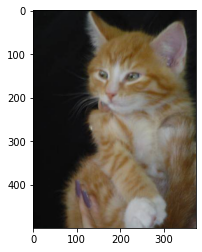

In [8]:
img = load_img('data/train/cat/cat.39.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)

### 3. Preparación de datos

#### 3.1 Data augmentation

Data augmentation es una técnica utilizada para extender el conjunto de datos de entrenamiento y así garantizar un mejor nivel de generalización y disminuir las posibilidades de un sobre ajuste.

La técnica básicamente consiste en la realización de transformaciones sobre unas imágenes en aspectos como: rotaciones, traslaciones, cambios de escala, etc.


In [9]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

A continuación se muestra un ejemplo de las salidas generadas a partir de la función *ImageDataGenerator*. El comando .flow () a continuación genera lotes de imágenes transformadas al azar y guarda los resultados en el directorio 'preview /'.

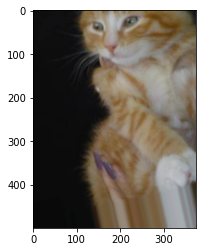

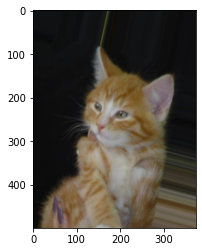

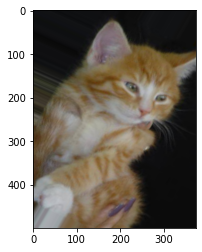

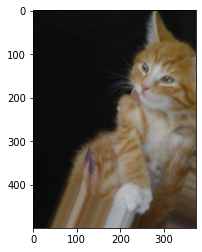

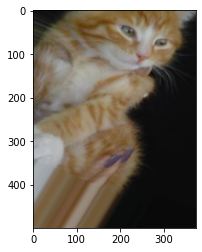

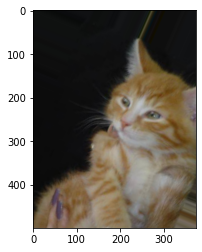

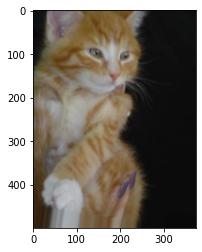

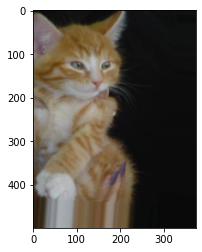

In [10]:
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)
i = 0

for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely
    plt.imshow(batch[0]/255) 
    plt.show()

In [11]:
# Dataset configuration
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)
batch_size = 256

Realización de data augmentation en dos pasos:
1. Configuración de los parametros para la aumentación de datos.
2. Parametrización de directorio de entrada, tamaño de las imagenes de salida, tamaño del batch a generar, etc.

In [12]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size= batch_size,
    class_mode='categorical')

steps_per_epoch = train_generator.n

Found 2000 images belonging to 2 classes.


Creación de generador de datos para los datos de validación:

In [13]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle=False,
    class_mode = 'categorical')

validation_steps = validation_generator.n

Found 400 images belonging to 2 classes.


### 4. Modelamiento


Configuración de hiperparametros:

In [14]:
# Hyperparameters
epochs = 25
loss = 'binary_crossentropy'
optimizer='rmsprop'
metrics=['accuracy']

#### 4.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura de Convolutional Network estructurada de la siguiente manera:

![Multilayer Perceptron](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/CNN.png?raw=true)

Las CNN cuentan con celdas de convolución (o capas de agrupación) y núcleos, cada uno con un propósito diferente. 

Los núcleos de convolución en realidad procesan datos de entrada, y las capas de agrupación los simplifican (principalmente utilizando funciones no lineales, como max), reduciendo características innecesarias. 

Las CNN típicamente son utilizadas para el reconocimiento de imágenes. La ventana de entrada se desliza a lo largo de la imagen, píxel por píxel. Los datos se pasan a capas de convolución, que forman un embudo (compresión de características detectadas). 

A partir de los términos de reconocimiento de imagen, la primera capa detecta gradientes, la segunda líneas, la tercera formas, etc. a la escala de objetos particulares. 

Las CNN comúnmente se unen a la capa convolucional final para el procesamiento de datos adicional.

In [15]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

![CNN](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/CNN2.PNG?raw=true)
[Herramienta de modelado](http://alexlenail.me/NN-SVG/LeNet.html)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

Y se 'compila', para poder entrenar los parámetros del modelo.

In [17]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [18]:
model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
    )

Epoch 1/25
8/8 [==============================] - 20s 2s/step - loss: 0.7999 - accuracy: 0.5132 - val_loss: 0.6247 - val_accuracy: 0.5000
Epoch 2/25
8/8 [==============================] - 16s 2s/step - loss: 0.6919 - accuracy: 0.5253 - val_loss: 0.6251 - val_accuracy: 0.5188
Epoch 3/25
8/8 [==============================] - 16s 2s/step - loss: 0.6812 - accuracy: 0.5667 - val_loss: 0.4663 - val_accuracy: 0.5138
Epoch 4/25
8/8 [==============================] - 16s 2s/step - loss: 0.6776 - accuracy: 0.5880 - val_loss: 0.7043 - val_accuracy: 0.6087
Epoch 5/25
8/8 [==============================] - 16s 2s/step - loss: 0.6668 - accuracy: 0.6140 - val_loss: 0.7024 - val_accuracy: 0.6200
Epoch 6/25
8/8 [==============================] - 17s 2s/step - loss: 0.6723 - accuracy: 0.5932 - val_loss: 0.5550 - val_accuracy: 0.6000
Epoch 7/25
8/8 [==============================] - 17s 2s/step - loss: 0.6635 - accuracy: 0.6165 - val_loss: 0.8380 - val_accuracy: 0.5750
Epoch 8/25
8/8 [==================

#### 4.2 Transfer Learning

![transfer](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/transfer.png?raw=true)

Para este laboratorio se utilizará MobileNet para realizar el proceso de transfer learning. Algunos de los modelos que se pueden utilizar se pueden consultar en el siguiente enlace: [Transfer Learning](https://keras.io/api/applications/)

* VGG
* ResNet
* Inception
* MobileNet
* DenseNet
* Xception

In [19]:
# build the MobileNet network
model_MobileNetV2 = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=train_generator.image_shape)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step


In [20]:
model_MobileNetV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [21]:
def create_model():
    model = Sequential(name='Transfered_Net')
    model.add(model_MobileNetV2)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(2,  activation='sigmoid',name='Salida'))

    model.layers[0].trainable = False
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
    return model

model_transfer = create_model()
model_transfer.summary()

Model: "Transfered_Net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 1280)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
Salida (Dense)               (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
history =model_transfer.fit(train_generator,
                   validation_data = validation_generator,
                   epochs = epochs
                   )

Epoch 1/25
8/8 [==============================] - 23s 3s/step - loss: 2.3221 - acc: 0.6833 - val_loss: 3.6246 - val_acc: 0.7950
Epoch 2/25
8/8 [==============================] - 16s 2s/step - loss: 0.6281 - acc: 0.8447 - val_loss: 2.1469 - val_acc: 0.8450
Epoch 3/25
8/8 [==============================] - 17s 2s/step - loss: 0.4940 - acc: 0.8658 - val_loss: 6.3543 - val_acc: 0.7100
Epoch 4/25
8/8 [==============================] - 17s 2s/step - loss: 0.7041 - acc: 0.8512 - val_loss: 0.4794 - val_acc: 0.9463
Epoch 5/25
8/8 [==============================] - 17s 2s/step - loss: 0.2513 - acc: 0.9252 - val_loss: 4.8298 - val_acc: 0.7563
Epoch 6/25
8/8 [==============================] - 17s 2s/step - loss: 0.6505 - acc: 0.8587 - val_loss: 1.8980 - val_acc: 0.8700
Epoch 7/25
8/8 [==============================] - 17s 2s/step - loss: 0.2039 - acc: 0.9310 - val_loss: 1.7607 - val_acc: 0.8825
Epoch 8/25
8/8 [==============================] - 17s 2s/step - loss: 0.5160 - acc: 0.8790 - val_loss: 2

### 5. Predicción

Comparemos los dos modelos, el que construimos con los valores dados, y el 'reciclado'.

In [23]:
score = model.evaluate(validation_generator,verbose=1)
print('Test loss: {:4f}\nTest Accuracy: {:4f}'.format(score[0], score[1]))

2/2 [==============================] - 2s 1s/step
Test loss: 0.491413
Test Accuracy: 0.705000


In [24]:
y_pred_1 = model.predict(validation_generator)
y_pred_1 = y_pred_1.argmax(axis=-1)
y_pred_1

array([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,

In [25]:
y_pred_2 = model_transfer.predict(validation_generator)
y_pred_2 = y_pred_2.argmax(axis=-1)
y_pred_2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,

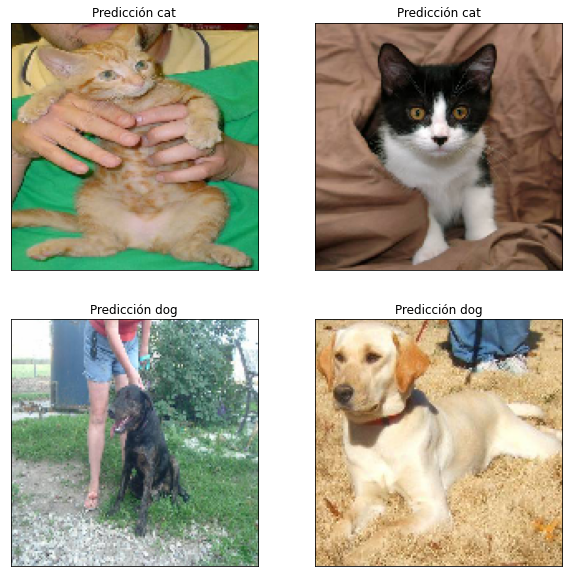

In [26]:
names = list(validation_generator.class_indices.keys())
img = [1,2,-1,-2]
plt.figure(figsize=(10,10))  

for c,i in enumerate(img):
  ax = plt.subplot(2,2,c+1)
  plt.imshow(validation_generator[0][0][i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  pred = names[y_pred_2[i]]
  ax.set(title='Predicción '+str(pred))


### 6. Validación

In [27]:
Y_test = validation_generator.labels

print('Reporte para el modelo 1')
print(classification_report(Y_test, y_pred_1, target_names=names))
print('Reporte para el modelo 2')
print(classification_report(Y_test, y_pred_2, target_names=names))

Reporte para el modelo 1
              precision    recall  f1-score   support

         cat       0.73      0.67      0.70       200
         dog       0.69      0.75      0.72       200

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

Reporte para el modelo 2
              precision    recall  f1-score   support

         cat       0.80      1.00      0.89       200
         dog       1.00      0.75      0.86       200

    accuracy                           0.88       400
   macro avg       0.90      0.88      0.87       400
weighted avg       0.90      0.88      0.87       400



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(54.260000000000005, 0.5, 'predicted label')

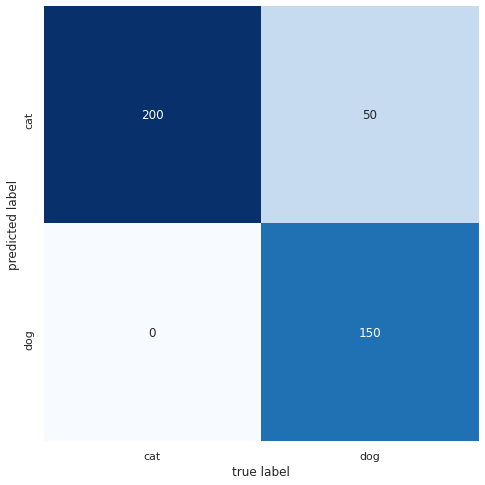

In [28]:
import seaborn as sns; sns.set()

plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_2)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False,
            xticklabels=names,
            yticklabels=names)
plt.xlabel('true label')
plt.ylabel('predicted label')

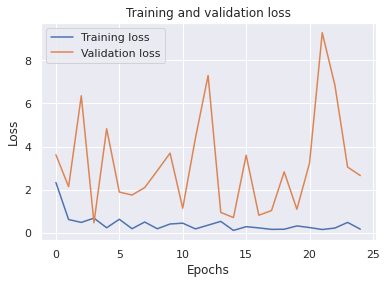

In [29]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

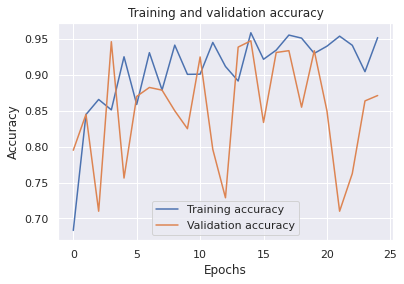

In [31]:
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Fine Tuning** 

Transfer learning entrena nuevamente la red, pero tiene en cuenta únicamente la parte de arriba. El cuerpo de la red, para este caso MobileNetV2 permanece bloqueda.

La acción de realizar el entrenamiento de la totalidad de la red incluido el cuerpo de la red transferida, se llama ***Fine Tuning***. Para esto se realiza el mismo procedimiento mostrado, pero en un paso adicional se desbloquean las capas de MobileNetV2 para que puedan ajustar sus pesos. Un ejemplo de como realizar dicha acción se muestra en la imagen a continuación:

![finetuning](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/finetuning.png?raw=true)

Para mas información pueden consultar el siguiente [enlace](https://torres.ai/data-augmentation-y-transfer-learning-en-keras-tensorflow/).


# Autoencoders for image denoising

## 0. Descarga de los datos
Primero, se descargan los datos y se visualizan que se hayan leido correctamente.

In [32]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## 1. Perfilamiento y entendimiento de los datos

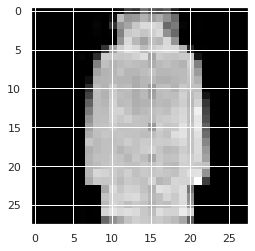

In [33]:
# select any random index from 1 to 60,000
i = random.randint(1,60000)
plt.imshow(X_train[i] , cmap = 'gray')

In [34]:
label = y_train[i]
label

4

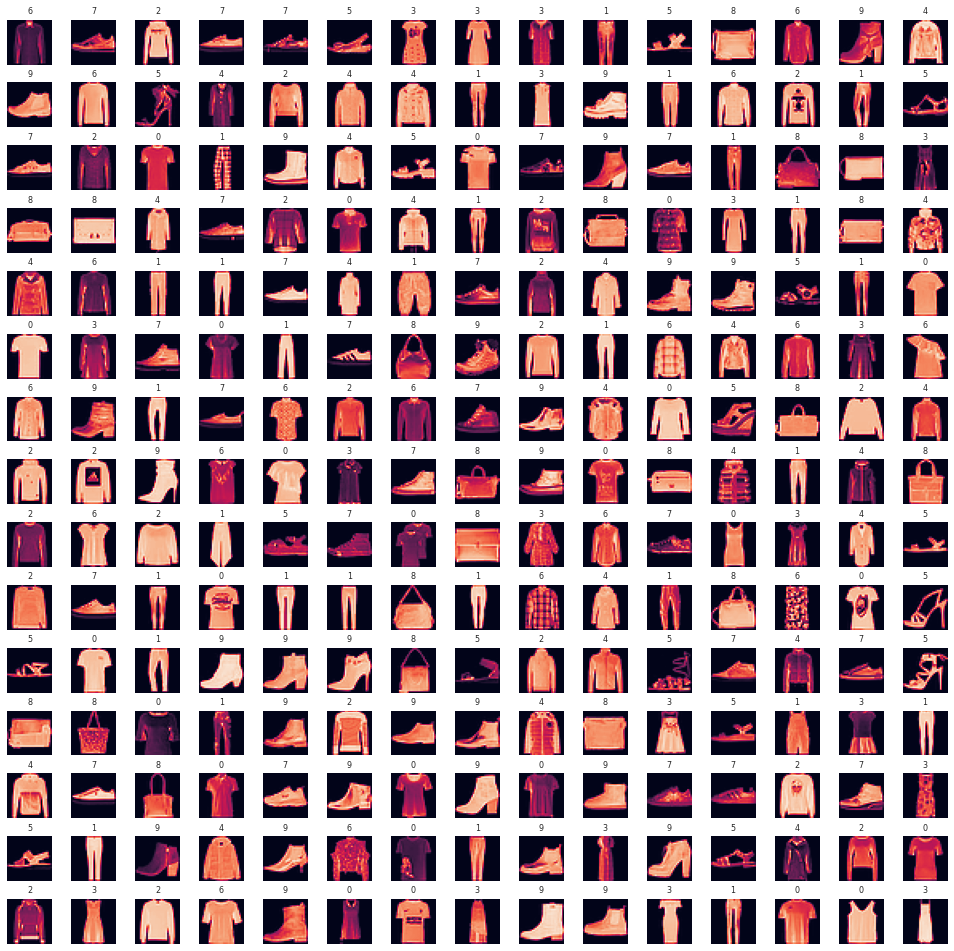

In [35]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    axes[i].imshow( X_train[index] )
    axes[i].set_title(y_train[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## 2. Preparación de datos

In [36]:
X_train = X_train / 255
X_test = X_test / 255

Se agrega ruido a los datos:

In [37]:
def noising_image(data, noise_factor):
  noise_dataset = []
  for img in data:
    noisy_image = img + noise_factor * np.random.randn(*img.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    noise_dataset.append(noisy_image)
  
  noise_dataset = np.array(noise_dataset)
  return noise_dataset

In [38]:
X_train_noise = noising_image(X_train, 0.2)
X_test_noise = noising_image(X_test, 0.2)

In [39]:
print(X_train_noise.shape)
print(X_test_noise.shape)

(60000, 28, 28)
(10000, 28, 28)


Visualizamos como es el resultado de agregar ruido a una de las imagenes:

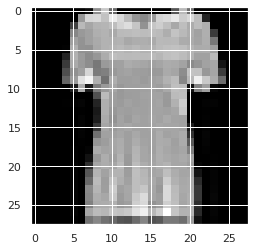

In [40]:
plt.imshow(X_train[10], cmap="gray")

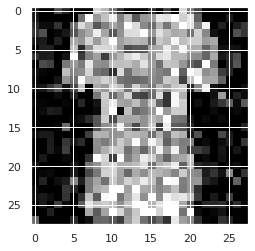

In [41]:
plt.imshow(X_train_noise[10], cmap="gray")

## 3. Modelamiento

### 3.1 Arquitectura

Para el desarrollo del laboratorio se utilizará una arquitectura de Autoencoder estructurada de la siguiente manera:

![Autoencoder](https://github.com/jcestevezc/Machine-Learning-Techniques/blob/master/Laboratorio%206/Autoencoder.png?raw=true)

Los codificadores automáticos o autoencoders se utilizan para la clasificación, agrupamiento y compresión de características.

Los autoencoders, por otro lado, pueden ser entrenados sin supervisión. Su estructura generalmente se caracteriza por: 
1. La cantidad de neuronas ocultas es menor que la cantidad de celdas de entrada.
2. La cantidad de celdas de salida es igual a la cantidad de celdas de entrada.
3. El autoencoder se entrena de manera en que la salida está lo más cerca posible de la entrada, obligando a los autoencoders a generalizar datos y realizar búsqueda de patrones comunes.

In [42]:
autoencoder = Sequential()

#Encoder
autoencoder.add(Conv2D(filters=16, kernel_size=3, strides=2, padding="same", input_shape=(28, 28, 1)))
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=2, padding="same"))

#Encoded image
autoencoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding="same"))

#Decoder
autoencoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same"))
autoencoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, activation='sigmoid', padding="same"))

In [43]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        1168      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [44]:
autoencoder.fit(X_train_noise.reshape(-1, 28, 28, 1),          
                X_train.reshape(-1, 28, 28, 1), 
                epochs=10, 
                batch_size=200, 
                validation_data=(
                    X_test_noise.reshape(-1, 28, 28, 1), 
                    X_test.reshape(-1, 28, 28, 1)
                    )
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.3859 - val_loss: 0.3158
Epoch 2/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.3063 - val_loss: 0.3035
Epoch 3/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.2985 - val_loss: 0.2986
Epoch 4/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.2947 - val_loss: 0.2954
Epoch 5/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.2922 - val_loss: 0.2934
Epoch 6/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.2907 - val_loss: 0.2923
Epoch 7/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.2897 - val_loss: 0.2915
Epoch 8/10
60000/60000 [==============================] - 3s 48us/step - loss: 0.2890 - val_loss: 0.2907
Epoch 9/10
60000/60000 [==============================] - 3s 47us/step - loss: 0.2884 - val_loss: 0.2904
Epoch

## 4. Predicción

In [45]:
predicted = autoencoder.predict(X_test_noise[:10].reshape(-1, 28, 28, 1))

## 6. Validación

In [46]:
evaluation = autoencoder.evaluate(X_test_noise.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1))
print('Test Accuracy : {:.3f}'.format(evaluation))

10000/10000 [==============================] - 1s 84us/step
Test Accuracy : 0.290


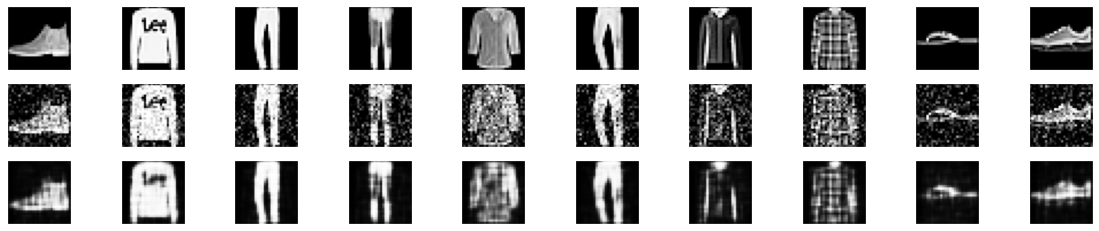

In [47]:
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(20,4))

for images, row in zip([X_test[:10], X_test_noise[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Taller
## Segundo Problema


Utilice el conjunto de datos Fashion-MNIST para construir un clasificador de imágenes de productos. Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:
<ol type="a">
  <li>Entrenamiento de un perceptrón multicapa.</li>
  <li>Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.</li>
  <li>Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).</li>
</ol>

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.
